In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error


import lightgbm as lgbm


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 4

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [59]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status']

feature_cols3 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status']

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status']

In [60]:
players

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds,DOY,mlbDebutYear,DebutAge
0,665482,Gilberto Celestino,1999-02-13,2021-06-02,Santo Domingo,NaN,Dominican Republic,72,170,8,Outfielder,False,1999,2021.0,22.0
1,593590,Webster Rivas,1990-08-08,2021-05-28,Nagua,NaN,Dominican Republic,73,219,3,First Base,True,1990,2021.0,31.0
2,661269,Vladimir Gutierrez,1995-09-18,2021-05-28,Havana,NaN,Cuba,73,190,1,Pitcher,True,1995,2021.0,26.0
3,669212,Eli Morgan,1996-05-13,2021-05-28,Rancho Palos Verdes,CA,USA,70,190,1,Pitcher,True,1996,2021.0,25.0
4,666201,Alek Manoah,1998-01-09,2021-05-27,Homestead,FL,USA,78,260,1,Pitcher,True,1998,2021.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,672695,Geraldo Perdomo,1999-10-22,NaN,Santo Domingo,NaN,Dominican Republic,74,203,6,Shortstop,True,1999,NaN,NaN
2057,672911,Jesus Cruz,1995-04-15,NaN,Salinas de Hidalgo,San Luis Potosi,Mexico,73,230,1,Pitcher,False,1995,NaN,NaN
2058,676103,Damon Jones,1994-09-30,NaN,Twin Falls,ID,USA,77,233,1,Pitcher,True,1994,NaN,NaN
2059,676755,Isaac Mattson,1995-07-14,NaN,Erie,PA,USA,74,205,1,Pitcher,True,1995,NaN,NaN


In [61]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [62]:
targets.shift(30)

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,628336.0,0.000394,0.013314,0.0,0.170707,1215.0,20210430.0
2506172,2021-05-01,645307.0,0.000000,0.006657,0.0,0.034141,1215.0,20210430.0
2506173,2021-05-01,488810.0,0.000000,0.009986,0.0,0.182087,1215.0,20210430.0
2506174,2021-05-01,592165.0,0.000000,0.153114,0.0,0.125185,1215.0,20210430.0


In [63]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [64]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [65]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'].astype(int) < 20210401)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [66]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

oof1, model1, score1 = fit_lgbm(
    x_train[feature_cols1], y_train['target1'],
    x_valid[feature_cols1], y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train[feature_cols2], y_train['target2'],
    x_valid[feature_cols2], y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train[feature_cols3], y_train['target3'],
    x_valid[feature_cols3], y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train[feature_cols4], y_train['target4'],
    x_valid[feature_cols4], y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.805718
Early stopping, best iteration is:
[39]	valid_0's l1: 0.805715
mae: 0.8057145485815109
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.56427
Early stopping, best iteration is:
[52]	valid_0's l1: 1.55372
mae: 1.5537217741446954
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.565797
[200]	valid_0's l1: 0.565797
[300]	valid_0's l1: 0.565797
[400]	valid_0's l1: 0.565797
Early stopping, best iteration is:
[312]	valid_0's l1: 0.565797
mae: 0.5657966719564418
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.3112
[200]	valid_0's l1: 1.26884
[300]	valid_0's l1: 1.23887
[400]	valid_0's l1: 1.22404
[500]	valid_0's l1: 1.22234
[600]	valid_0's l1: 1.21637
[700]	valid_0's l1: 1.2102
[800]	valid_0's l1: 1.20294
[900]	valid_0's l1: 1.19999
[1000]	valid_0's l1: 1.1969
[1100]	valid_0's l1: 1.19327
[1200]	vali

In [67]:
score: 0.9954547214078484


In [68]:
oof_df = pd.DataFrame()
oof_df['date_playerId'] = train['date'][~_index].reset_index(drop=True).astype(str) + '_' + x_valid['label_playerId'].values.astype(str)
oof_df['target1'] = oof1
oof_df['target2'] = oof2
oof_df['target3'] = oof3
oof_df['target4'] = oof4
oof_df

,date_playerId,target1,target2,target3,target4
0,20210401_1845,0.017397,2.762538,0.021642,1.838502
1,20210401_1770,0.000018,0.316768,0.002977,0.064122
2,20210401_1663,0.002726,0.463765,0.028899,4.857959
3,20210401_1756,0.025594,2.736525,0.032895,0.754728
4,20210401_1704,0.000931,0.630443,0.112623,0.351035
...,...,...,...,...,...
61825,20210430_159,0.000018,0.216164,0.000724,0.374477
61826,20210430_555,0.000018,0.067002,0.000001,0.019761
61827,20210430_437,0.000018,0.263384,0.001113,0.213023
61828,20210430_1611,0.001804,0.252967,0.000778,0.398826


In [69]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [70]:
models = [model1, model2, model3, model4]
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

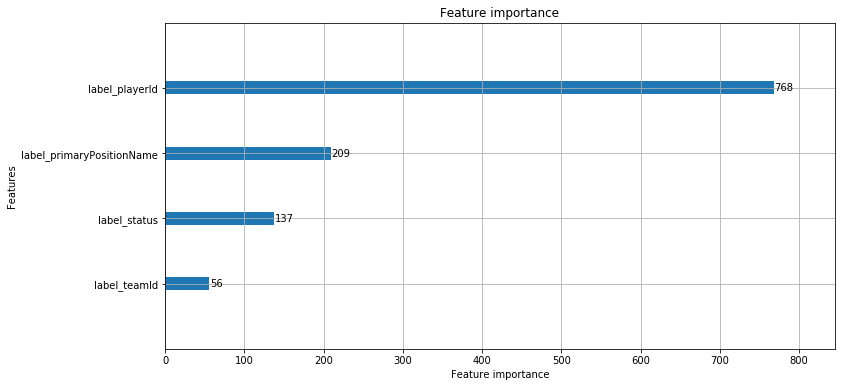

In [71]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

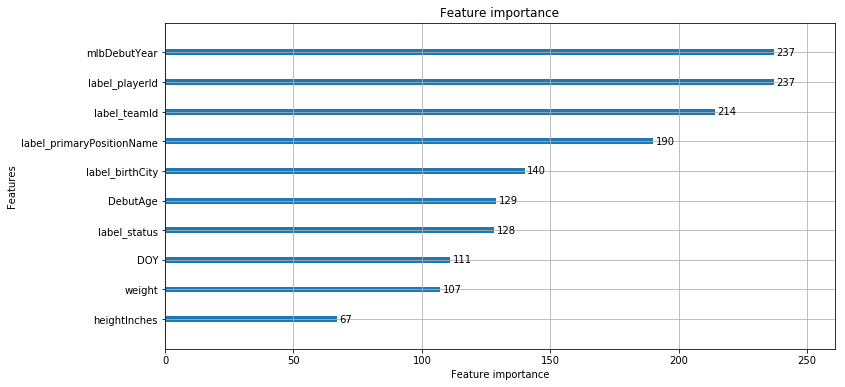

In [72]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

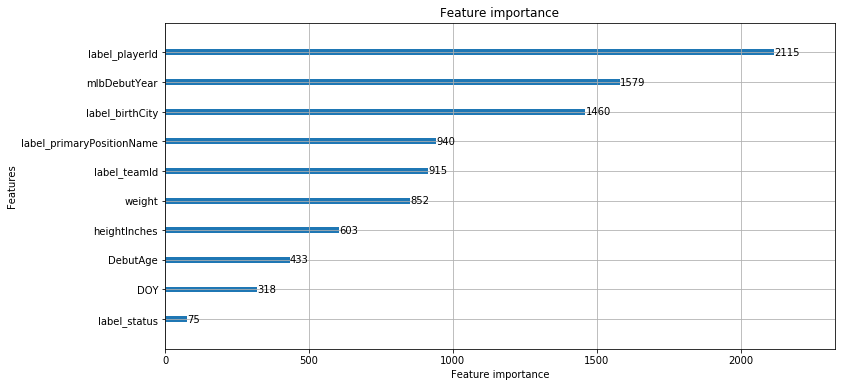

In [73]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

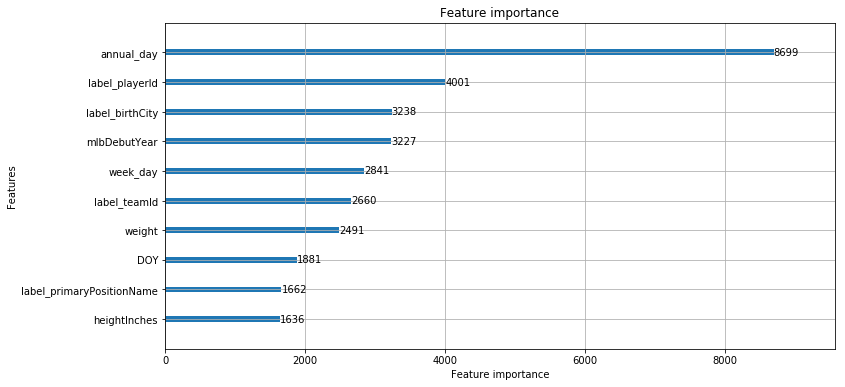

In [74]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [22]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [23]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')

test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [24]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [25]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,7.811665,9.658618,5.698936,4.548788
1,20210427_543475,0.455741,4.859775,3.150001,2.346946
2,20210427_592866,0.622950,2.756700,0.786827,0.716302
3,20210427_452678,0.695356,5.799647,1.553753,2.010001
4,20210427_570257,0.394891,2.356924,0.399929,0.578931
...,...,...,...,...,...
1182,20210427_593590,0.120659,0.417598,0.148858,0.290887
1183,20210427_642180,0.034780,1.571588,1.250571,0.872281
1184,20210427_663399,0.000000,0.596551,0.004434,0.077048
1185,20210427_664199,0.082524,1.988508,0.376264,0.552088
